In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [5]:
def preprocess_data(df, selected_features, log_transform_features=None, one_hot_encode=False):
    X = df[selected_features].copy()
    
    if log_transform_features is None:
        log_transform_features = {
            'age_mean_mass': False,
            'velDisp_ppxf_res': False,
            '[M/H]_mean_mass': False
        }

    for feature, do_log in log_transform_features.items():
        if do_log and feature in X.columns:
            X[feature] = np.log10(X[feature] + 1e-10)
    
    return X, X.columns.tolist()

In [6]:
df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']

log_transform_config = {
    'age_mean_mass': False,
    'velDisp_ppxf_res': False,
    'MgFe': False,
    '[M/H]_mean_mass': False
}

# Preprocess data
X, feature_names = preprocess_data(
    df, 
    selected_features, 
    log_transform_features=log_transform_config,
)
y = df['DoR'].values

Epoch 1/500
14/14 [==============================] - 0s 6ms/step - loss: 0.5378 - mse: 0.1931 - val_loss: 0.5210 - val_mse: 0.1640 - lr: 0.0010
Epoch 2/500
14/14 [==============================] - 0s 1ms/step - loss: 0.4375 - mse: 0.1204 - val_loss: 0.4376 - val_mse: 0.1114 - lr: 0.0010
Epoch 3/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3656 - mse: 0.0711 - val_loss: 0.3765 - val_mse: 0.0753 - lr: 0.0010
Epoch 4/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3365 - mse: 0.0552 - val_loss: 0.3295 - val_mse: 0.0497 - lr: 0.0010
Epoch 5/500
14/14 [==============================] - 0s 1ms/step - loss: 0.3032 - mse: 0.0387 - val_loss: 0.2966 - val_mse: 0.0340 - lr: 0.0010
Epoch 6/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2876 - mse: 0.0338 - val_loss: 0.2734 - val_mse: 0.0246 - lr: 0.0010
Epoch 7/500
14/14 [==============================] - 0s 1ms/step - loss: 0.2682 - mse: 0.0269 - val_loss: 0.2578 - val_mse: 0.0204 - lr:

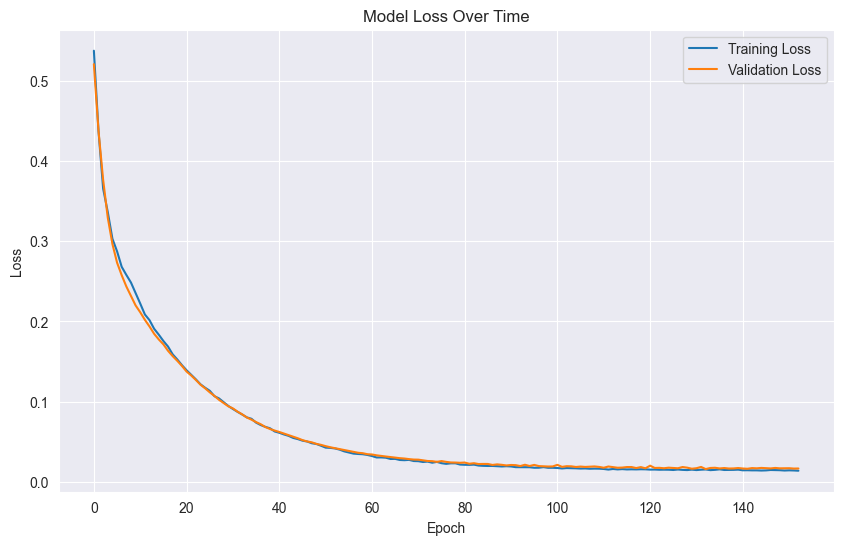

3/3 [==============================] - 0s 656us/step

Test Set Performance:
R² Score: 0.7406
RMSE: 0.0827
MAE: 0.0679
14/14 [==============================] - 0s 408us/step

Full Dataset Performance:
R² Score: 0.7271
RMSE: 0.0780
MAE: 0.0636


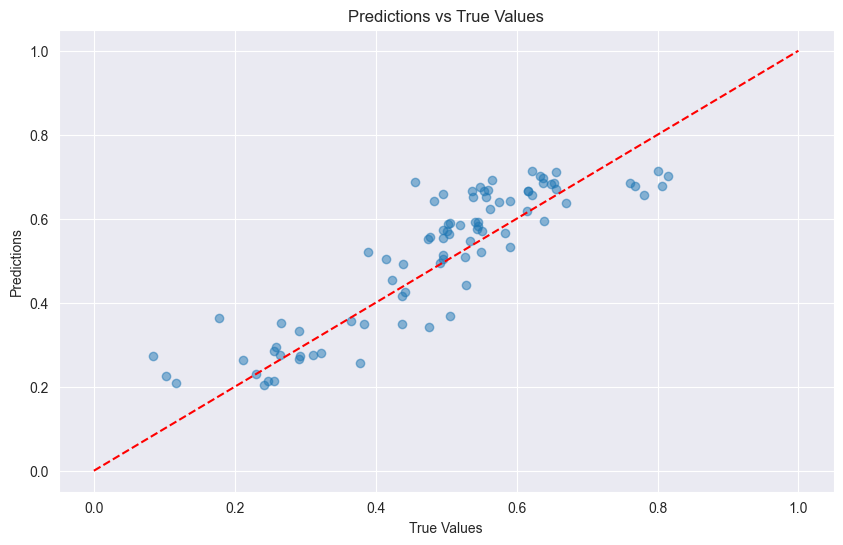

In [7]:


def jitter_data(X, y, jitter_factor=0.03, n_samples=2):
    """Create jittered versions of data, focusing on extreme values."""
    low_threshold = np.percentile(y, 15)
    high_threshold = np.percentile(y, 85)
    extreme_mask = (y <= low_threshold) | (y >= high_threshold)
    
    X_extreme = X[extreme_mask]
    y_extreme = y[extreme_mask]
    
    X_aug_list = [X]
    y_aug_list = [y]
    
    for i in range(n_samples):
        noise_X = np.random.normal(0, jitter_factor * X_extreme.std(axis=0), X_extreme.shape)
        X_jittered = X_extreme + noise_X
        
        noise_y = np.random.normal(0, jitter_factor * y_extreme.std() * 0.5, y_extreme.shape)
        y_jittered = y_extreme + noise_y
        
        X_aug_list.append(X_jittered)
        y_aug_list.append(y_jittered)
    
    X_augmented = np.vstack(X_aug_list)
    y_augmented = np.concatenate(y_aug_list)
    
    return X_augmented, y_augmented

def custom_extremes_loss(y_true, y_pred):
    mse = tf.keras.backend.square(y_true - y_pred)
    weights = 1 + 2 * tf.keras.backend.abs(y_true - tf.keras.backend.mean(y_true))
    return tf.keras.backend.mean(mse * weights)

# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create jittered data and combine
X_train_scaled, y_train = jitter_data(X_train_scaled, y_train)

# Build model
input_dim = X_train_scaled.shape[1]  # Account for potential one-hot encoding
model = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(12, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='linear')
])

# Compile
model.compile(
    optimizer='adam',
    loss=custom_extremes_loss,
    weighted_metrics=['mse']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Fit
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate
y_pred_nn = model.predict(X_test_scaled)
print("\nTest Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_nn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_nn):.4f}")


X_full = df[selected_features]

X_full_scaled = scaler.fit_transform(X_full)
y_full_pred = model.predict(X_full_scaled)

print("\nFull Dataset Performance:")
print(f"R² Score: {r2_score(y, y_full_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_full_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y, y_full_pred):.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid(True)
plt.show()